In [2]:
%load_ext autoreload
%autoreload 2

Number of samples: 1136


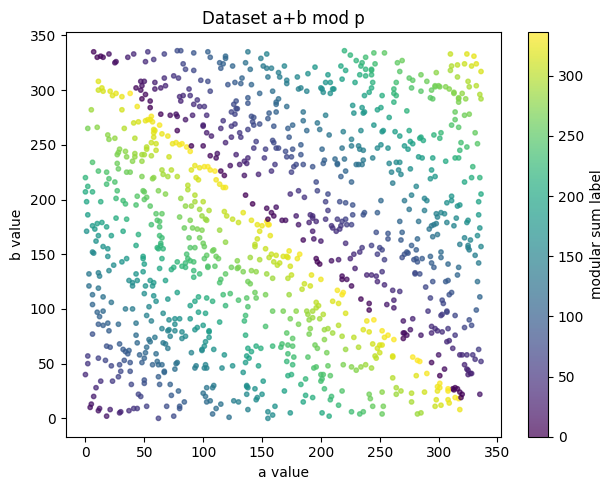

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from utils.config import MODELS_DIR
import os
from tasks.arithmetic import get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig, visualize_data
from models.transformer import Transformer

device = t.device("cuda" if t.cuda.is_available() else "cpu")

config = ArithmeticDatasetConfig(
  p=337,
  noise_frac=0
)

train_dataloader, val_dataloader, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, val_frac=0.99)
visualize_data(train_dataloader)
data_iter = iter(train_dataloader)

In [2]:
from tasks.arithmetic import load_model_and_dataset

checkpoint_dir = os.path.join(MODELS_DIR, 'arithmetic_transformer/p113_d32')

cp = load_model_and_dataset(Transformer, checkpoint_dir, checkpoint=20, device=device)

data_iter = iter(cp.dataloader)

cp.val_loss

0.0011111031881610822

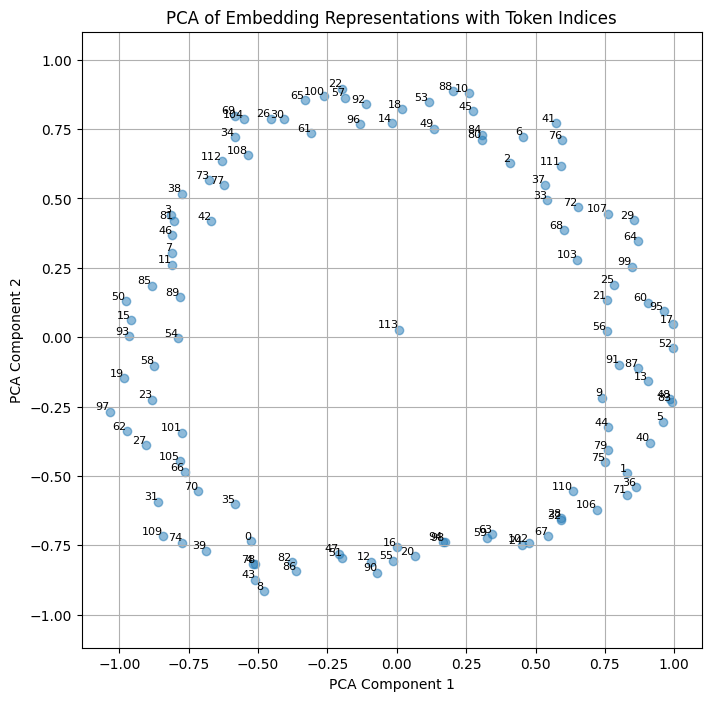

In [3]:
from models.other import MLP, MLPWithEmbedding
from models.transformer import Transformer
from models.transformer import Embedding
from utils.helpers import CrossEntropyHighPrecision
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

representations = cp.model.embedding.W_embed

integers = t.arange(0, config.p, device=device).unsqueeze(1)  # Shape (p, 1)

# Plot PCA of representations with labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(representations.T.cpu().detach().numpy()) 
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)

# Add labels to each point
for i, (x, y) in enumerate(X_pca):
  plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

plt.title('PCA of Embedding Representations with Token Indices')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.axis('equal')
plt.show()



In [4]:
from numpy.ma.core import nonzero

np.array([0.000001])

array([1.e-06])

In [ ]:
criterion = nn.CrossEntropyLoss()


print(x.shape, y.shape)
print(x.dtype, y.dtype)
loss = criterion(x,y)

loss

torch.Size([3, 4]) torch.Size([3])
torch.float32 torch.int64


tensor(0.7437, device='cuda:0')

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

rows = []
for x in np.linspace(16.5, 16.8, 4):
    rows.append([x, 
                F.log_softmax(torch.tensor([x, 0]).float(), dim=0)[0].item(),
                F.log_softmax(torch.tensor([x, 0]).to(torch.float64), dim=0)[0].item()])
pd.DataFrame(rows, columns=['x', 'float32', 'float64'])


,x,float32,float64
0,16.5,-1.192093e-07,-6.825603e-08
1,16.6,-1.192093e-07,-6.176061e-08
2,16.7,0.000000e+00,-5.588331e-08
3,16.8,0.000000e+00,-5.056531e-08


In [40]:
def forward(logits, labels):
  logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
  prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
  loss = -torch.mean(prediction_logprobs)
  return loss


tensor(6.1967e-08, dtype=torch.float64)

In [ ]:
logits = torch.tensor([[16.6, 0.0], [16.7, 0.0]], dtype=torch.float32)
labels = torch.tensor([], dtype=torch.long)  # All labels are 0

logprobs = F.log_softmax(logits.to(torch.float32), dim=-1)
print(logprobs)
prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
print(prediction_logprobs)
loss = -torch.mean(prediction_logprobs)

tensor([[-1.1921e-07, -1.6600e+01],
        [ 0.0000e+00, -1.6700e+01]])


RuntimeError: Index tensor must have the same number of dimensions as input tensor